<a href="https://colab.research.google.com/github/rivkms/2021-School-Record-AI-Material/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터셋 불러오기

In [1]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/brain_tumor.zip"
!unzip -qo brain_tumor.zip 
!rm brain_tumor.zip

--2021-07-04 13:11:15--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/brain_tumor.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.23
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7919366 (7.6M) [application/zip]
Saving to: ‘brain_tumor.zip’

brain_tumor.zip     100%[===================>]   7.55M  3.52MB/s    in 2.1s    

2021-07-04 13:11:18 (3.52 MB/s) - ‘brain_tumor.zip’ saved [7919366/7919366]



#필요한 모듈 Import

In [2]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,MaxPool2D
from keras.layers import Conv2D, Reshape

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

**Brain Tumor Detection **
https://cainvas.ai-tech.systems/use-cases/brain-tumor-detection-app/

#사진파일 회전 등 변환 후 저장
사진들의 개수가 부족하기에 이 방법을 이용하여 다양한 사진들을 만들어준다. 

In [3]:
# Defining the dataset directory
image_dir="brain_tumor_dataset/"
# Defining t=directory to store augmented images 
os.makedirs('brain_tumor_dataset/augmented-images')
os.makedirs('brain_tumor_dataset/augmented-images/yes')
os.makedirs('brain_tumor_dataset/augmented-images/no')

In [4]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1,
                                   save_to_dir=save_to_dir, 
                                   save_prefix=save_prefix, 
                                   save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [5]:
augmented_data_path ='brain_tumor_dataset/augmented-images/'

augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')

augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

#사진 크롭뜨기
위 사진들에서 위에 공백이 많이 생기고 필요없는 부분이 생기기에 해당 부분을 제거하는 함수이다. 
opencv를 이용하고, 이 방법을 통하여 프로세싱하면 사진 사이즈가 변하기에 사이즈를 바꿔줘야한다. 

In [6]:

def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, 
                        left=False, right=False,labelbottom=False, 
                        labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, 
                        left=False, right=False,labelbottom=False, 
                        labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


위의 함수를 실행하면 다음과 같은 실행결과가 나온다. 

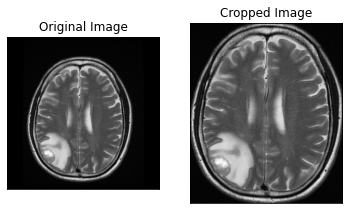

In [7]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

#파일 불러오고 처리하기
위의 함수를 경로 내 모든 파일에 적용하는 함수이다. 

In [9]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    Y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                Y.append([1])
            else:
                Y.append([0])
                
    X = np.array(X)
    Y = np.array(Y)
    
    # Shuffle the data
    X, Y = shuffle(X, Y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'Y shape is: {Y.shape}')
    
    return X, Y

위의 함수를 이용하여 argumented-images속의 no,yes에 들어있는 사진들을 가공한다. 

In [12]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, Y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 224, 224, 3)
y shape is: (2064, 1)


#데이터셋 미리보기
plt.subplot을 이용하여 미리 데이터셋들의 미리보기를 제작한다. 

In [14]:
def plot_sample_images(X, Y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(Y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

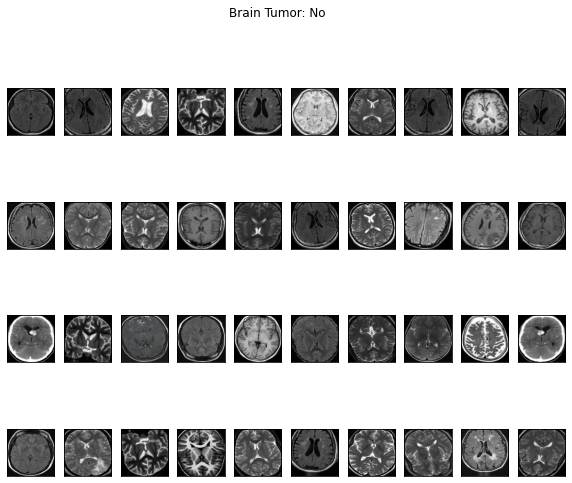

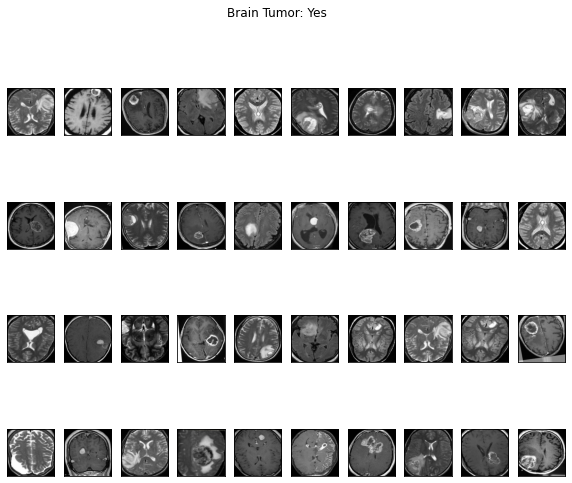

In [16]:
plot_sample_images(X, Y)

In [17]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.1)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 2740
number of validation examples = 153
number of test examples = 152


In [ ]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=7, input_shape=(224, 224, 3), activation='relu'))
model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(MaxPooling2D(pool_size=4))
model.add(MaxPooling2D(pool_size=4))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 218, 218, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 218, 218, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5409      
Total params: 10,273
Trainable params: 10,209
Non-trainable params: 64
___________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
59/59 [==============================] - 126s 2s/step - loss: 0.6219 - accuracy: 0.6887 - val_loss: 0.7571 - val_accuracy: 0.4712
Epoch 2/22
59/59 [==============================] - 125s 2s/step - loss: 0.5221 - accuracy: 0.7679 - val_loss: 0.6238 - val_accuracy: 0.6442
Epoch 3/22
59/59 [==============================] - 126s 2s/step - loss: 0.4546 - accuracy: 0.7954 - val_loss: 0.8532 - val_accuracy: 0.5192
Epoch 4/22
59/59 [==============================] - 126s 2s/step - loss: 0.3878 - accuracy: 0.8374 - val_loss: 0.5308 - val_accuracy: 0.7500
Epoch 5/22
59/59 [==============================] - 125s 2s/step - loss: 0.3016 - accuracy: 0.8767 - val_loss: 0.4903 - val_accuracy: 0.7788
Epoch 6/22
59/59 [==============================] - 126s 2s/step - loss: 0.2444 - accuracy: 0.9036 - val_loss: 0.4687 - val_accuracy: 0.8077
Epoch 7/22
59/59 [==============================] - 126s 2s/step - loss: 0.2167 - accuracy: 0.9192 - val_loss: 0.3818 - val_accuracy: 0.8269
Epoch 8/22
59

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 3s 533ms/step - loss: 0.2884 - accuracy: 0.8947


[0.2884182929992676, 0.8947368264198303]

In [ ]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
model.save("brain_tumor_model.h5")

In [ ]:
!deepCC brain_tumor_model.h5

/bin/bash: deepCC: command not found
